In [2]:
import datetime
import time
import unittest
import pandas as pd
import pytz
import matplotlib.pyplot as plt

In [3]:
from tigeropen.common.consts import BarPeriod
from tigeropen.quote.quote_client import QuoteClient
from tigeropen.tiger_open_config import TigerOpenClientConfig

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [5]:
def get_client_config():
    """
    https://quant.itigerup.com/#developer 开发者信息获取
    """
    # 港股牌照需用 props_path 参数指定token路径，如 '/Users/xxx/xxx/', 如不指定则取当前路径
    client_config = TigerOpenClientConfig(props_path='tiger_openapi_config.properties')
    return client_config

In [10]:
# 调用上方定义的函数生成用户配置ClientConfig对象
client_config = get_client_config()

# 随后传入配置参数对象来初始化QuoteClient
quote_client = QuoteClient(client_config)

SYMBOL = "symbol"
TIME = "time"
CLOSE = "close"
DATE = "date"

# 需要请求的k线bar的总个数.  total number of requested bars.
BARS_TOTAL_NUMBER = 2000

# 每次请求bar的个数，系统限制每个symbol每次最多请求1200个bar.
# number of bars per request, the system limits each symbol to a maximum of 1200 bars per request.
BARS_BATCH_SIZE = 300

# 每次请求symbol的个数，系统限制每次最多请求50个symbol
# number of symbols per request, the system limits each request to a maximum of 50 symbols.
SYMBOLS_BATCH_SIZE = 50

# 每次请求的间隔时间，防止过快的请求频率触发系统限流. 单位：秒
# The interval between each request, to prevent requests too fast to trigger the system rate limit. Time unit: second
REQUEST_INTERVAL = 0.5

In [11]:
def request_bars(symbols, period, end_time, bars_batch_size):
        """
        请求k线. Request history bars.
        :param symbols: like ['AAPL', 'TSLA']
        :param period: k线周期. tigeropen.common.consts.BarPeriod. like BarPeriod.DAY
        :param end_time: end time in timestamp format. like 1645499400000
        :param bars_batch_size: 每个symbol限制请求的bar数量. bars limit size of each symbol
        :return:
        """
        symbols = list(symbols)
        result = pd.DataFrame()
        for i in range(0, len(symbols), SYMBOLS_BATCH_SIZE):
            part = symbols[i:i + SYMBOLS_BATCH_SIZE]
            quote = quote_client.get_bars(part, period=period, end_time=end_time, limit=bars_batch_size)
            #result = result.append(quote)
            result = pd.concat([result, quote])
            # to avoid rate limit
            time.sleep(REQUEST_INTERVAL)
        return result

In [12]:
# HK market
symbols = ['00700', '01024', '03690', '00992', '00762', '00998', '02020', '01109', '00981', '03988', '01398']
timezone = 'Asia/Shanghai'

end = int(datetime.datetime.today().timestamp() * 1000)
history = pd.DataFrame()
for i in range(0, BARS_TOTAL_NUMBER, BARS_BATCH_SIZE):
    if i + BARS_BATCH_SIZE <= BARS_TOTAL_NUMBER:
        limit = BARS_BATCH_SIZE
    else:
        limit = i + BARS_BATCH_SIZE - BARS_TOTAL_NUMBER
    end_time = datetime.datetime.fromtimestamp(end/1000, pytz.timezone(timezone))
    print(f'query {len(symbols)} symobls history, end_time:{end} -- {end_time}, limit:{limit}')
    # 其他周期可修改period参数. 
    part = request_bars(symbols=symbols, period=BarPeriod.MONTH, end_time=end, bars_batch_size=BARS_BATCH_SIZE)
    part[DATE] = pd.to_datetime(part[TIME], unit='ms').dt.tz_localize('UTC').dt.tz_convert(timezone)
    if (len(part[TIME]) == 0): 
        break
    end = min(part[TIME])
    history = pd.concat([history, part])
history.set_index([DATE], inplace=True)
history.sort_index(inplace=True)

# 2004年3月1日
history.drop(history[history[TIME] < 1078070400000].index, inplace=True)

history.drop('time', axis=1, inplace=True)
history.drop('amount', axis=1, inplace=True)
history.drop('next_page_token', axis=1, inplace=True)

print(history)

query 11 symobls history, end_time:1707006816374 -- 2024-02-04 08:33:36.374000+08:00, limit:300
query 11 symobls history, end_time:920217600000 -- 1999-03-01 00:00:00+08:00, limit:300
query 11 symobls history, end_time:760032000000 -- 1994-02-01 00:00:00+08:00, limit:300
                          symbol    open    high     low   close     volume
date                                                                       
2004-03-01 00:00:00+08:00  01109   0.856   0.856   0.678   0.695  146043611
2004-03-01 00:00:00+08:00  00762   6.188   6.373   4.187   4.341  943712332
2004-03-01 00:00:00+08:00  00992   1.709   1.724   1.414   1.465  992021580
2004-03-01 00:00:00+08:00  00981  24.300  25.500  21.000  23.500  243745020
2004-04-01 00:00:00+08:00  00992   1.476   1.595   1.207   1.243  640727938
...                          ...     ...     ...     ...     ...        ...
2024-02-01 00:00:00+08:00  03988   2.940   2.970   2.890   2.910  562207743
2024-02-01 00:00:00+08:00  01024  39.150  42

In [13]:
ind = history.groupby('date').agg({'open':'sum', 'high':'sum', 'low':'sum', 'close':'sum', 'volume':'sum'}).reset_index()
indexation = pd.DataFrame(ind)
indexation.set_index([DATE], inplace=True)
indexation.sort_index(inplace=True)

print(indexation)

                              open     high      low    close       volume
date                                                                      
2004-03-01 00:00:00+08:00   33.053   34.453   27.279   30.001   2325522543
2004-04-01 00:00:00+08:00   29.775   32.066   23.520   24.185   1719837467
2004-05-01 00:00:00+08:00   23.918   25.629   20.443   24.777   1451572423
2004-06-01 00:00:00+08:00   25.406   26.042   21.654   23.288   6177291483
2004-07-01 00:00:00+08:00   22.619   23.554   20.456   22.420   2699905880
...                            ...      ...      ...      ...          ...
2023-10-01 00:00:00+08:00  634.464  680.811  589.197  614.975  13218242329
2023-11-01 00:00:00+08:00  615.705  689.777  573.888  632.340  12248677396
2023-12-01 00:00:00+08:00  630.190  634.050  526.680  578.360  11946134505
2024-01-01 00:00:00+08:00  587.260  595.050  481.370  499.740  16392545851
2024-02-01 00:00:00+08:00  497.950  530.470  490.520  510.610   1430733128

[240 rows x 5 columns]


In [14]:
import cufflinks as cf

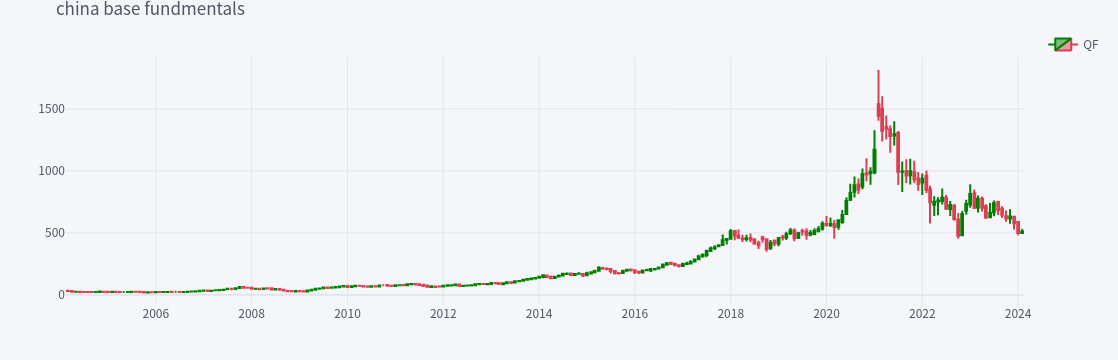

In [63]:
cf.set_config_file(offline=True, world_readable=True)
qf = cf.QuantFig(indexation, title="china base fundmentals", legend="right", name="QF")
# qf.add_volume()
# qf.add_trendline('2004-03-01','2024-01-01',on='close',textangle=0)
qf.iplot(up_color='green',down_color='red')

In [64]:
close = indexation[CLOSE]
# 计算月收益率
returns = close.pct_change().dropna()
# 计算滚动的12月历史波动性（标准差）
volatility = returns.rolling(window=12).std()
# 查看有效月份的年化波动性
volatility.dropna(inplace=True)
print(volatility)

date
2005-03-01 00:00:00+08:00    0.085692
2005-04-01 00:00:00+08:00    0.066302
2005-05-01 00:00:00+08:00    0.065681
2005-06-01 00:00:00+08:00    0.065215
2005-07-01 00:00:00+08:00    0.065099
                               ...   
2023-10-01 00:00:00+08:00    0.144943
2023-11-01 00:00:00+08:00    0.098639
2023-12-01 00:00:00+08:00    0.093454
2024-01-01 00:00:00+08:00    0.090220
2024-02-01 00:00:00+08:00    0.085633
Name: close, Length: 228, dtype: float64


In [65]:
# 计算每月的绝对价格变动
absolute_price_change = close.diff()
absolute_price_change.dropna(inplace=True)
print(absolute_price_change)

date
2004-04-01 00:00:00+08:00    -5.816
2004-05-01 00:00:00+08:00     0.592
2004-06-01 00:00:00+08:00    -1.489
2004-07-01 00:00:00+08:00    -0.868
2004-08-01 00:00:00+08:00    -0.307
                              ...  
2023-10-01 00:00:00+08:00   -31.909
2023-11-01 00:00:00+08:00    17.365
2023-12-01 00:00:00+08:00   -53.980
2024-01-01 00:00:00+08:00   -78.620
2024-02-01 00:00:00+08:00    10.870
Name: close, Length: 239, dtype: float64


In [66]:
volume = indexation['volume']
# 市场数据组合
market_data = pd.concat([volume, volatility, absolute_price_change], axis = 1, ignore_index=False)
market_data.columns = ['market_volume', 'volatility', 'price_change']
market_data.dropna(how='any', inplace=True)
print(market_data)

                           market_volume  volatility  price_change
date                                                              
2005-03-01 00:00:00+08:00     2992970673    0.085692        -2.287
2005-04-01 00:00:00+08:00     1730266839    0.066302         0.009
2005-05-01 00:00:00+08:00     1844742121    0.065681         0.004
2005-06-01 00:00:00+08:00     2259054336    0.065215         1.077
2005-07-01 00:00:00+08:00     2372992161    0.065099         1.067
...                                  ...         ...           ...
2023-10-01 00:00:00+08:00    13218242329    0.144943       -31.909
2023-11-01 00:00:00+08:00    12248677396    0.098639        17.365
2023-12-01 00:00:00+08:00    11946134505    0.093454       -53.980
2024-01-01 00:00:00+08:00    16392545851    0.090220       -78.620
2024-02-01 00:00:00+08:00     1430733128    0.085633        10.870

[228 rows x 3 columns]


In [67]:
# 计算指数的函数
def calculate_fear_greed_index(data):
    # 标准化数据
    normalized_volatility = (data['volatility'] - data['volatility'].min()) / (data['volatility'].max() - data['volatility'].min())
    normalized_volume = (data['market_volume'] - data['market_volume'].min()) / (data['market_volume'].max() - data['market_volume'].min())
    normalized_price_change = (data['price_change'] - data['price_change'].min()) / (data['price_change'].max() - data['price_change'].min())
    # 定义恐慌和贪婪的权重
    volatility_weight = 0.4
    volume_weight = 0.3
    price_change_weight = 0.3
    # 计算指数
    data['fear_greed_index'] = (normalized_volatility * volatility_weight + 
                                 normalized_volume * volume_weight + 
                                 normalized_price_change * price_change_weight) * 100
    return data

In [68]:
# 计算恐慌贪婪指数
fear_greed_index_data = calculate_fear_greed_index(market_data)
print(fear_greed_index_data['fear_greed_index'])

date
2005-03-01 00:00:00+08:00    32.158454
2005-04-01 00:00:00+08:00    26.221870
2005-05-01 00:00:00+08:00    26.076648
2005-06-01 00:00:00+08:00    26.127323
2005-07-01 00:00:00+08:00    26.128697
                               ...    
2023-10-01 00:00:00+08:00    51.124172
2023-11-01 00:00:00+08:00    39.880769
2023-12-01 00:00:00+08:00    34.543938
2024-01-01 00:00:00+08:00    33.713872
2024-02-01 00:00:00+08:00    32.336537
Freq: MS, Name: fear_greed_index, Length: 228, dtype: float64


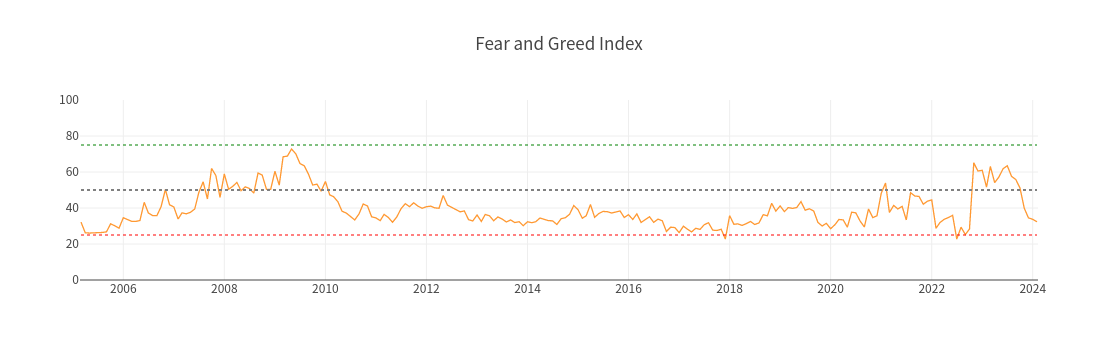

In [73]:
layout = {
    'shapes': [
        {
            'type': 'line',
            'x0': fear_greed_index_data.index.min(),
            'y0': 75,  # 指定线的y值
            'x1': fear_greed_index_data.index.max(),
            'y1': 75,  # 线的y值保持不变，因为这是一条水平线
            'line': {
                'color': 'green',
                'width': 1,
                'dash': 'dot',  # 线的样式（实线、虚线等）
            },
        },
        {
            'type': 'line',
            'x0': fear_greed_index_data.index.min(),
            'y0': 50,  # 指定线的y值
            'x1': fear_greed_index_data.index.max(),
            'y1': 50,  # 线的y值保持不变，因为这是一条水平线
            'line': {
                'color': 'gray',
                'width': 2,
                'dash': 'dot',  # 线的样式（实线、虚线等）
            },
        },
        {
            'type': 'line',
            'x0': fear_greed_index_data.index.min(),
            'y0': 25,  # 指定线的y值
            'x1': fear_greed_index_data.index.max(),
            'y1': 25,  # 线的y值保持不变，因为这是一条水平线
            'line': {
                'color': 'red',
                'width': 1,
                'dash': 'dot',  # 线的样式（实线、虚线等）
            },
        }
    ],
    'yaxis': {
        'range': [0, 100]  # 设置y轴的最小值和最大值
    },
    'y0': 50,  # 指定线的y值
    'title': 'Fear and Greed Index'
}

fear_greed_index_data['fear_greed_index'].iplot(kind='line', layout=layout)